In [1]:
# import libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings
from collections import deque
warnings.filterwarnings('ignore')

In [2]:
# small graph
SAMPLE_GRAPH_EDGES = [('A', 'B'),('A', 'C'),('A', 'E'),('B', 'C'),('B', 'F'),
 ('C', 'F'),('E', 'H'),('F', 'I'),('D', 'G'),('D', 'H'),('G', 'I'),
 ('G', 'J'),('H', 'J'),('I', 'K'),('J', 'K')]

Nodes: 11 Edges: 15


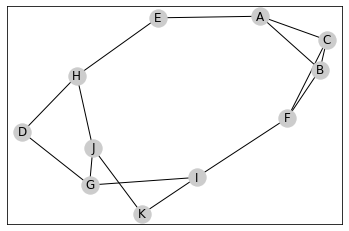

In [3]:
G = nx.Graph()
G.add_edges_from(SAMPLE_GRAPH_EDGES)
print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))
nx.draw_networkx(G, node_color='#CCCCCC')


# Algorithms

In [8]:
# returns a tuple of 2 things
# 1. graph of the spanning tree starting at vertex v
# 2. partition of vertices (chain stucture)
def find_spanning_tree(G, v):
    st = nx.Graph()
    
    partition = []
    
    # parent of vertex
    parent = {}
    parent[v] = None
    
    dq = deque()
    dq.append((v, 0))
    
    # traverse the graph in bfs fashion
    while dq:
        cur, dist = dq.popleft()
        if cur != v:
            st.add_edge(cur, parent[cur])
            
        if len(partition) == dist:
            partition.append([])
        partition[dist].append(cur)

        for neighbour in G.adj[cur]:
            if neighbour in parent:
                continue
            parent[neighbour] = cur
            dq.append((neighbour, dist + 1))
            
    return st, partition
        

In [9]:
# returns true if the graph C(st) = G - st is compatible with the chain structure of G
# return False otherwise
def is_compatible(G, st, partition):
    st_edges = set(st.edges())
    level = {}
    for i in range(len(partition)):
        for v in partition[i]:
            level[v] = i
            
    for e in G.edges():
        if e in st_edges:
            continue
            
        
        level1 = level[e[0]]
        level2 = level[e[1]]
        
        if abs(level1 - level2) > 1:
            return False
        
    return True
        
        
    

5
[['A'], ['B', 'C', 'E'], ['F', 'H'], ['I', 'D', 'J'], ['G', 'K']]


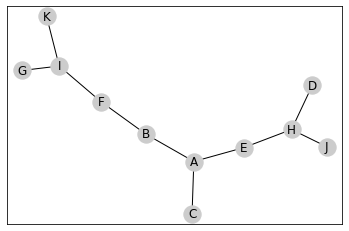

In [10]:
# Algo 1
# INPUT: G: a networkx undirected graph object
# OUTPUT: l : length of the chain
#         final_partition: list of lists (each list is a partition of vertices)
#         spanning_tree: a networx undirected graph object, the underlying spanning tree
def semi_chain_structure(G):
    spanning_tree = None
    final_partition = []
    l = 0
    
    # for each node in the graph, determine a spanning tree rooted at that node
    for v in G.nodes():
        st, partition = find_spanning_tree(G, v)
        
        if is_compatible(G, st, partition) and len(partition) > l:
            l = len(partition)
            final_partition = partition
            spanning_tree = st
        
    return l, final_partition, spanning_tree
        
l, final_partition, spanning_tree = semi_chain_structure(G)
print(l)
print(final_partition)
nx.draw_networkx(spanning_tree, node_color='#CCCCCC')

In [11]:
# Algo 2
# INPUT: G: a networkx undirected graph object, a tree
#        v: starting vertex of the tree
# OUTPUT: longest_branches : list of lists (each list is represents a branch)
#         num_longest: int, number of longest branches
#         len_longest: int, length of the longest branch
def find_longest_branches(G, v):

    # recursive helper function
    def find_longest_branches_rec(G, v):
        longest_branches = []
        num_longest = 1
        len_longest = 0

        # call the algorithm recursively for each child of v
        for child in G.adj[v]:
            if child in visited:
                continue
                
            visited.add(child)
            longest_branches_r, num_longest_r, len_longest_r = find_longest_branches_rec(G, child)
            if len_longest_r > len_longest:
                longest_branches = longest_branches_r
                len_longest = len_longest_r
                num_longest = num_longest_r
                
            elif len_longest_r == len_longest:
                longest_branches.extend(longest_branches_r)
                num_longest += num_longest_r
        
        while len(longest_branches) < num_longest:
            longest_branches.append(deque())
            
        for i in range(num_longest):
            longest_branches[i].appendleft(v)
            
        return longest_branches, num_longest, len_longest+1
    
    # keep track of the vertices visited
    visited = set()
    visited.add(v)
    return find_longest_branches_rec(G, v)
    
longest_branches, num_longest, len_longest = find_longest_branches(spanning_tree, 'A')
print(longest_branches, num_longest, len_longest)

[deque(['A', 'B', 'F', 'I', 'G']), deque(['A', 'B', 'F', 'I', 'K'])] 2 5


[['A'], ['B', 'C', 'E'], ['F', 'H'], ['I', 'D', 'J'], ['G', 'K']]


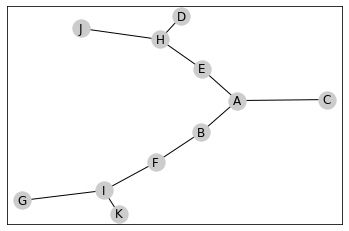

In [12]:
# Algo 3
# INPUT: G: a networkx undirected graph object
#        v: starting vertex (optional)
# OUTPUT: new_st: a networx undirected graph object, the underlying spanning tree
#         chain_struct: list of lists (each list is a partition of vertices)   
def approximate_chain_structure(G, v=None):

    if v is None:
        v = list(G.nodes())[0]
        
    # determine a spanning tree starting at vertex v
    st, partition = find_spanning_tree(G, v)
    
    chain_len = len(partition)
    new_st = st
    chain_struct = partition
    
    # determine the longest branches of spanning tree
    longest_branches, num_longest, len_longest = find_longest_branches(st, v)
    # for each longest branch, determine the spanning tree rooted at last vertex
    for branch in longest_branches:
        last_vertex = branch[-1]

        st2, partition2 = find_spanning_tree(G, last_vertex)
        if len(partition2) > chain_len:
            chain_len = len(partition2)
            new_st = st2
            chain_struct = partition2 

    return new_st, chain_struct


st, partition = approximate_chain_structure(G, 'A')
print(partition)
nx.draw_networkx(st, node_color='#CCCCCC')
    
                

('I', 13.974691494688162)
('I', 21)
('I', 57)
('A', 1164)


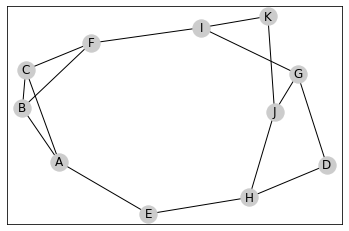

In [13]:
# Algo 4
# INPUT: G: a networkx undirected graph object
#        p: float, an exponent
#        v: starting vertex (optional)
#        N: nodes to be discarded
# OUTPUT: p_center: vertex with the lowest p-center
#         p_centrality: float, position centrality of the p-center vertex
def approx_pcenter(G, p, v=None, N=set()):
    if v is None:
        v = list(G.nodes())[0]

    # determine a spanning tree starting at vertex v
    st, partition = find_spanning_tree(G, v)

    # determine the longest branches of spanning tree
    longest_branches, num_longest, len_longest = find_longest_branches(st, v)

    p_center = None
    p_centrality = None
    st_p_center = None
    partition_p_center = None

    for branch in longest_branches:
        for n in branch:
            # determine the spanning tree at vertex n
            st2, partition2 = find_spanning_tree(G, n)

            # determine the p-position centrality of n
            p_centrality_n = 0
            for k in range(1, len(partition2)):
                card = len(partition2[k])
                p_centrality_n += k * (card ** p)

            if n not in N and (p_centrality is None or p_centrality_n < p_centrality):
                p_centrality = p_centrality_n
                p_center = n
                st_p_center = st2
                partition_p_center = partition2

    #if partition_p_center is not None:
    #    print(f"p:{p}, v:{v}, chainlen:{len(partition_p_center)}")
    return p_center, p_centrality



print(approx_pcenter(G, 0.5))
print(approx_pcenter(G, 1))
print(approx_pcenter(G, 2))
print(approx_pcenter(G, 5))
nx.draw_networkx(G, node_color='#CCCCCC')


                
                    

[['I', 13.974691494688162], ['F', 14.392304845413264], ['G', 14.392304845413264], ['K', 14.87831517751085]]
[['I', 21], ['F', 22], ['G', 22], ['A', 24]]
[['I', 57], ['F', 58], ['G', 58], ['A', 60]]
[['A', 156], ['B', 156], ['F', 166], ['G', 166]]
[['A', 420], ['B', 420], ['F', 490], ['G', 490]]
[['A', 1164], ['B', 1164], ['F', 1462], ['G', 1462]]


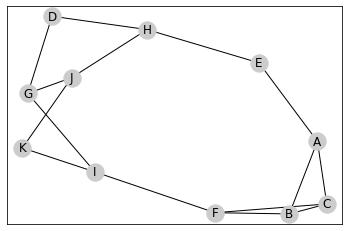

In [14]:
# Algo 5
# INPUT: G: a networkx undirected graph object
#        p: float, an exponent
#        k: an integer, top k p-center vertices
#        v: starting vertex (optional)
# OUTPUT: List of k items. Each item is a tuple (p_center, p_centrality)
#         p_center: vertex with the i-th lowest p-center
#         p_centrality: float, position centrality of the i-th lowest p-center vertex
def top_k_pcenter(G, p, k, v=None):
    # vertex already included in the p-center
    N = set()
    # list to be returned
    pcenters = []
    
    if v is None:
        v = list(G.nodes())[0]
    
    for i in range(k):
        x, y = approx_pcenter(G, p, v, N)
        if x is not None:
            pcenters.append([x, y])
            N.add(x)
            
    return pcenters


print(top_k_pcenter(G, 0.5, 4))
print(top_k_pcenter(G, 1, 4))
print(top_k_pcenter(G, 2, 4))
print(top_k_pcenter(G, 3, 4))
print(top_k_pcenter(G, 4, 4))
print(top_k_pcenter(G, 5, 4))
nx.draw_networkx(G, node_color='#CCCCCC')


# Game of Thrones
## Finding p-centers
https://github.com/mathbeveridge/asoiaf/tree/4b2673ae90738cb60f82d7b8a15e8c180bb8ac61

In [15]:
# INPUT: d, dictionary of key and numeric values
#        n, number of nodes
# OUTPUT: list of 'n' (key, value) pairs, keys are included in the decreasing order
# finds and returns the top 'n' (key, value) pairs whose values are the highest if rev is True
# if rev is False, then the top n lowest values are returned
def top_n_nodes(d, n, rev=True):
    values = list(d.items())
    values.sort(key=lambda x: x[1], reverse=rev)
    return values[:n]

In [16]:
GOT_FILENAME = "asoiaf-all-edges.csv"
GOT_GRAPH_EDGES = []
with open(GOT_FILENAME, 'r') as infile:
    alllines = infile.readlines()
    for line in alllines[1:]:
        GOT_GRAPH_EDGES.append(line.strip().split(',')[:2])
        
print(GOT_GRAPH_EDGES[:5])

[['Addam-Marbrand', 'Brynden-Tully'], ['Addam-Marbrand', 'Cersei-Lannister'], ['Addam-Marbrand', 'Gyles-Rosby'], ['Addam-Marbrand', 'Jaime-Lannister'], ['Addam-Marbrand', 'Jalabhar-Xho']]


In [17]:
GOT = nx.Graph()
GOT.add_edges_from(GOT_GRAPH_EDGES)
print("Nodes:", len(GOT.nodes()), "Edges:", len(GOT.edges()))

Nodes: 796 Edges: 2823


## Heuristics

In [18]:
def avg_chain_len(G, nodes):
    chain_lens = []
    for n in nodes:
        st, partition = approximate_chain_structure(GOT, n)
        chain_lens.append(len(partition))
        
    return sum(chain_lens)/len(chain_lens)


In [19]:
def top_avg_pcenters(G, nodes, k, p):
    knew = 3*k
    
    pcenters = dict()
    for n in nodes:
        l = top_k_pcenter(G, p, knew, n)
        #print(n, l, '\n')
        for x, y  in l:
            pcenters[x] = pcenters.get(x, 0) + y
            
    return top_n_nodes(pcenters, k, False)
    

In [21]:
# 5 lists, one for each heuristic
manual = ['Tyrion-Lannister', 'Robert-Baratheon', 'Eddard-Stark', 'Cersei-Lannister', 'Jon-Snow', 'Stannis-Baratheon',
           'Robb-Stark', 'Theon-Greyjoy', 'Daenerys-Targaryen', 'Eddard-Stark']

random_nodes1 = random.choices(list(GOT.nodes()), k = 10)

mixture = random.choices(list(GOT.nodes()), k = 10) + manual

betweenness_map = nx.algorithms.centrality.betweenness_centrality(GOT)
betweenness_nodes = [x[0] for x in top_n_nodes(betweenness_map, 10)]

closeness_map = nx.algorithms.centrality.closeness_centrality(GOT)
closeness_nodes = [x[0] for x in top_n_nodes(closeness_map, 10)]

all_nodes = {'manual':manual, 'random':random_nodes1,  
             'mixture':mixture, 'betweenness':betweenness_nodes, 'closeness':closeness_nodes}


In [22]:
# compare the average chain length
for key in all_nodes:
    print(key, avg_chain_len(GOT, all_nodes[key]))


manual 10.0
random 10.0
mixture 10.0
betweenness 10.0
closeness 10.0


In [23]:
# compare the heuristics
# WARNING
# THIS BLOCK WILL TAKE A LONG TIME TO RUN (~5 min on my PC, M1 Mac)
# WARNING

k = 3
p_vals = [0.3, 0.7, 1, 2, 3, 4, 5]

# find the average value of p-centrality for different p for each list
all_pvals_lst = {}
for p in p_vals:
    all_pvals = {}
    for key in all_nodes:
        res = top_avg_pcenters(GOT, all_nodes[key], k, p)
        #print(key, p, res)
        all_pvals[key] = [x[1] for x in res]
    
    for key in all_pvals:
        all_pvals[key] = sum(all_pvals[key]) / len(all_pvals[key])
    print(p, all_pvals, '\n')
    all_pvals_lst[p] = all_pvals
    
print(all_pvals_lst)

0.3 {'manual': 48.892980329980254, 'random': 54.53010583328387, 'mixture': 53.54729732664463, 'betweenness': 50.14887916821882, 'closeness': 48.892980329980254} 

0.7 {'manual': 338.7830688213763, 'random': 369.45561396487165, 'mixture': 348.50871277029665, 'betweenness': 335.812389506435, 'closeness': 335.812389506435} 

1 {'manual': 1728.3333333333333, 'random': 1840.6666666666667, 'mixture': 1738.6666666666667, 'betweenness': 1714.6666666666667, 'closeness': 1714.6666666666667} 

2 {'manual': 547648.3333333334, 'random': 557930.0, 'mixture': 567796.3333333334, 'betweenness': 564073.6666666666, 'closeness': 565691.6666666666} 

3 {'manual': 192227446.33333334, 'random': 186449374.66666666, 'mixture': 198563513.66666666, 'betweenness': 200953354.33333334, 'closeness': 207612834.0} 

4 {'manual': 69668773270.33333, 'random': 65720412484.666664, 'mixture': 66628649688.333336, 'betweenness': 69857661979.0, 'closeness': 76919960802.0} 

5 {'manual': 25250309048296.332, 'random': 239063609

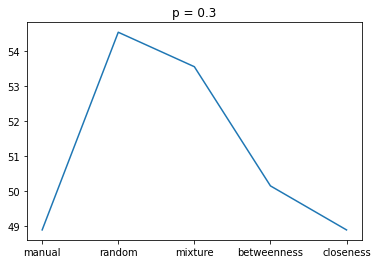

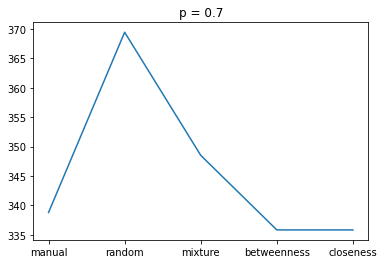

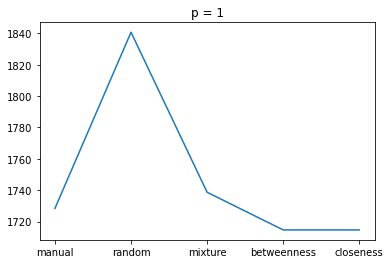

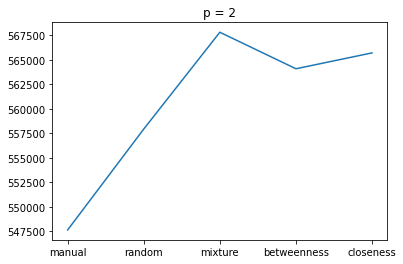

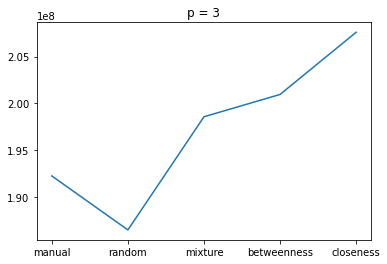

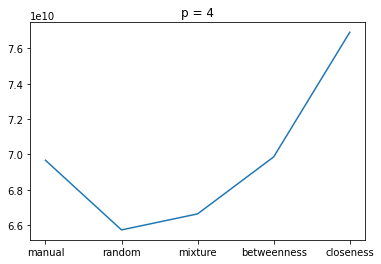

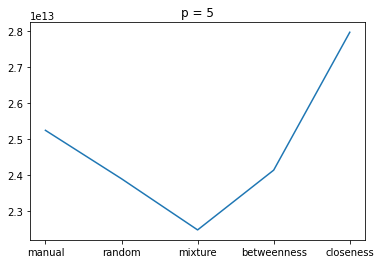

In [24]:
# plot the value of position centrality for different lists for different values of p
for k, all_pvals in all_pvals_lst.items():
    plt.title("p = " + str(k))
    plt.plot(*zip(*all_pvals.items()))
    plt.show()

In [26]:
# WARNING
# THIS BLOCK WILL TAKE A LONG TIME TO RUN (~5 min on my PC, M1 mac)
# WARNING

# print the top p-centers for different values of p for each list
p_vals = [0.5, 1, 2, 5]
k = 3
for p in p_vals:
    all_pvals = {}
    for key in all_nodes:
        res = top_avg_pcenters(GOT, all_nodes[key], k, p)
        print("List:", key, ", p:", p, "\n p-centers:", res, '\n')

List: manual , p: 0.5 
 p-centers: [('Robert-Baratheon', 116.34519416713376), ('Tyrion-Lannister', 126.80778069661194), ('Stannis-Baratheon', 128.29046625942135)] 

List: random , p: 0.5 
 p-centers: [('Tyrion-Lannister', 126.80778069661194), ('Jon-Snow', 134.0536899033972), ('Mace-Tyrell', 148.69355250226587)] 

List: mixture , p: 0.5 
 p-centers: [('Tyrion-Lannister', 126.80778069661194), ('Stannis-Baratheon', 128.29046625942135), ('Jaime-Lannister', 133.82111969510356)] 

List: betweenness , p: 0.5 
 p-centers: [('Robert-Baratheon', 116.34519416713376), ('Tyrion-Lannister', 126.80778069661194), ('Stannis-Baratheon', 128.29046625942135)] 

List: closeness , p: 0.5 
 p-centers: [('Robert-Baratheon', 116.34519416713376), ('Tyrion-Lannister', 126.80778069661194), ('Stannis-Baratheon', 128.29046625942135)] 

List: manual , p: 1 
 p-centers: [('Tyrion-Lannister', 1669), ('Robert-Baratheon', 1731), ('Jon-Snow', 1785)] 

List: random , p: 1 
 p-centers: [('Tyrion-Lannister', 1669), ('Jon-Sn